## Survival Analysis
- Survival Analysis, a.k.a Churn Analysis is a popular topic in Applied Data Science. It is the analysis of a special type of outcome variable i.e., the time until an event occurs. The event can be death, subscription cancellation, etc. 

- The survival curve, or survival function, is defined as $S(t) = P(T>t)$, where $T$ is the actual survival time.
- $S(t)$ indicates the probability that the subject survives at least up to time $t$. 
- This notebook employs the BrainCancer datasets [1] as an example to summaries some basic concepts of survival analysis. Please refer to [2] for more details about those concepts.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import proportional_hazard_test

In [2]:
df = pd.read_csv('brain_cancer.csv')
df['_id'] = df.index

### Kaplan-Meier Survival Curve

#### Manual Calculation of Kaplan-Meier Survival Curve

Let $d_1 < d_2 < · · · < d_k$ denote the $k$ unique death times among the noncensored subjects, by Law of Total Probability,

$$ P(T>d_k) = P(T>d_k|T>d_{k-1})P(T>d_{k-1}) + P(T>d_k|T \leq d_{k-1})P(T \leq d_{k-1}) $$

Since $P(T>d_k|T \leq d_{k-1})=0$ i.e. it is impossible for a subject to survive up to $d_k$ if it doesn't survive until $d_{k-1}$, we can conclude that:

$$ S(d_k) = P(T>d_k) = P(T>d_k|T>d_{k-1})P(T>d_{k-1}) $$

Solving this recursively, we get

$$ S(d_k) = P(T>d_k|T>d_{k-1})P(T>d_{k-1}) \times ... \times P(T>d_2|T>d_1)P(T>d_1) $$

A natural estimation of $P(T>d_k|T>d_{k-1})$ (Conditional Survival Probability at time $d_k$ given the subject is still at risk at time $d_{k-1}$) is $(r_k − q_k)/r_k$, where $r_k$ and $q_k$ denote the number of subjects at risk up to time $d_k$ and died at time $d_k$.

In [3]:
def count_at_risk(time, df=df):
    return (df['time']>=time).sum()

In [4]:
df_survival = df.loc[df['status']==1].groupby(
    'time', as_index=False
)['_id'].count().rename(columns={
    '_id':'q',
    'time':'death_time'
})
df_survival.loc[-1] = [0, 0]  # adding the 1st row with time 0 and 0 death
df_survival.index = df_survival.index + 1  # shifting index
df_survival.sort_index(inplace=True)
# # adding the last row with the max time and 0 death
# df_survival.loc[df_survival.shape[0]] = [df['time'].max(), 0]
df_survival['r'] = df_survival['death_time'].apply(count_at_risk)

df_survival['cond_survival_prob'] = (
    (df_survival['r'] - df_survival['q']) / df_survival['r']
)

df_survival['survival_prob'] = df_survival['cond_survival_prob'].cumprod()


In [5]:
df['q'], df['r'] = np.nan, np.nan
df.loc[df['status']==1, 'q'] = df.loc[df['status']==1].groupby('time')['_id'].transform('count')
df.loc[df['status']==1, 'r'] = df.loc[df['status']==1, 'time'].apply(count_at_risk)
df['cond_survival_prob'] = (df['r'] - df['q']) / df['r']
df = df.sort_values(['time', 'status'], ascending=[True, False]).reset_index(drop=True)
df['survival_prob'] = df['cond_survival_prob'].cumprod().ffill()

df_survival = df[['time', 'survival_prob']].drop_duplicates(subset=['time'])
df_survival.loc[-1] = [0, 1]  # adding the 1st row with time 0 and 0 death
df_survival.index = df_survival.index + 1  # shifting index
df_survival.sort_index(inplace=True)

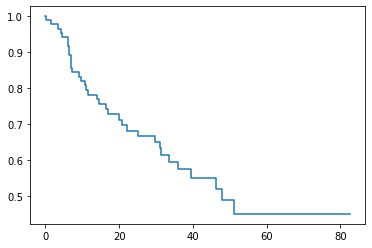

In [6]:
plt.step(x=df_survival['time'], y=df_survival['survival_prob'], where='post')
display()

#### Kaplan-Meier Survival Curve using Lifelines KaplanMeierFitter

We can check the correctness of the manual calculation using the lifelines library [3]. 

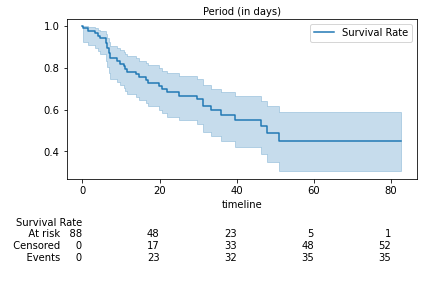

In [7]:
kmf = KaplanMeierFitter()
kmf.fit(df["time"], df["status"], label='Survival Rate')
kmf.plot(at_risk_counts=True)
plt.xlabel('Period (in days)')
plt.ylabel('Survival rate')
display()

We see the 2 survival curves are similar, in fact they are actually identical:

In [8]:
assert all(
    np.isclose(
        df_survival['survival_prob'].values, 
        kmf.survival_function_['Survival Rate'].values
    )
)

However, the lifelines library also provides us the 95% confidence interval at each point of the curve. The actual values of the interval are shown as follows:

In [13]:
kmf.confidence_interval_.head()

,Male_lower_0.95,Male_upper_0.95
0.00,1.000000,1.000000
0.07,0.846155,0.996691
1.18,0.846155,0.996691
1.41,0.824563,0.988017
4.16,0.796010,0.976573


We fit multiple survival curves for different cohorts, e.g. separated by sex:

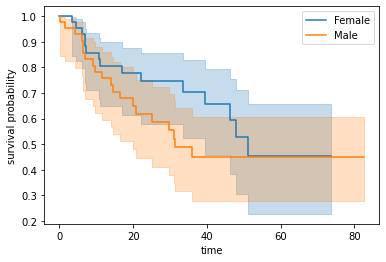

In [14]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

for name, grouped_df in df.groupby('sex'):
    kmf.fit(grouped_df["time"], grouped_df["status"], label=name)
    kmf.plot()

plt.xlabel('time')
plt.ylabel('survival probability')
display()

### Cox Proportional Hazards Models

#### Hazard Function
The Hazard function / Hazard rate is defined as:

$$ H(t) = \lim_{\Delta t \to 0} \frac{P(t < T \leq t + \Delta t | T>t)}{\Delta t} $$

where $P(t < T \leq t + \Delta t | T>t)$ is the probability of the death at the time right after $t$, and $H(t)$ denotes the death rate. It can be proved that:

$$ H(t) = f(t)/S(t) $$

where f(t) is the PDF of T.

#### Fitting Cox Proportional Hazards Models

The Proportional Hazards Assumption:
$$ h(t|x_i) = h_0(t) exp(\sum_{j=1}^p x_{ij} \beta_j) $$

where $h_0(t) \geq 0$ is an unspecified function, known as the baseline hazard, $p$ denotes the number of predictors, $x_i$ denote the covariate $x$ of the $i^{th}$ example.

$exp(\sum_{j=1}^p x_{ij} \beta_j)$ is the relative risk of the $i^{th}$ example over the risk of an example with $x_{ij}=0$ for all $j$.

One unit increment in $x_{ij}$ leads to an increment in $h(t|x_i)$ by a factor of $exp(\beta_j)$.

If the assumption is true, the graph of the survival function over time should be with parallel curves, i.e. hazards can change over time, but their ratio between levels of predictors remains constant.

Objective: Minimize the following partial likelihood with respect to $\beta$: 
$$\Pi_{i:\delta_i=1} \frac{exp(\sum_{j=1}^p x_{ij}\beta_j)}{\sum_{i':y_{i'} \geq {y_i}} exp(\sum_{j=1}^p x_{i'j}\beta_j)}$$

The partial likelihood only involved non-cencored subjects. 
- The numerator represents the partial hazards of the subject who died at time $y_i$
- The denominator represents the partial hazards of all the subjects who at risk at time $y_i$

In [26]:
df_cph = df[['time','status','sex','ki','gtv']].copy()
df_cph['sex'] = (df_cph['sex']=='Male').astype(np.int8)

Using sex only:

In [29]:
cph = CoxPHFitter()
cph.fit(df_cph, duration_col='time', event_col='status',  formula="sex")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -137.43
         time fit was run = 2021-11-28 08:04:49 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.41       1.50       0.34            -0.26             1.08                 0.77                 2.94

             z    p   -log2(p)
covariate                     
sex       1.19 0.23       2.10
---
Concordance = 0.56
Partial AIC = 276.86
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.12

Using sex, ki, and gtv:

In [30]:
cph = CoxPHFitter()
cph.fit(df_cph, duration_col='time', event_col='status',  formula="sex + ki + gtv")

cph.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -131.15
         time fit was run = 2021-11-28 08:05:37 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
gtv         0.04       1.04       0.02             0.00             0.07                 1.00                 1.07
ki         -0.04       0.96       0.02            -0.07            -0.01                 0.93                 0.99
sex         0.40       1.49       0.34            -0.28             1.07                 0.76                 2.91

              z    p   -log2(p)
covariate                      
gtv        2.08 0.04       4.72
ki        -2.50 0.01       6.32
sex        1.15 0.25       2.01
---
Concordance = 0.67
Partial AIC = 268.30
log-likelihood ratio test = 14.00 on 3 df
-log2(p) of ll-ratio test = 8.43

#### Testing the Proportional Hazards Assumption

The Null Hypothesis is the Proportional Hazards Assumption holds:

In [82]:
cph.check_assumptions(df_cph, show_plots=True, columns=['sex','ki','gtv'])

Proportional hazard assumption looks okay.


C:\Users\css91\anaconda3\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]

In [33]:
proportional_hazard_test(cph, df_cph)

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
         test_name = proportional_hazard_test

---
     test_statistic    p  -log2(p)
gtv            0.16 0.69      0.55
ki             0.09 0.77      0.39
sex            0.29 0.59      0.76

#### Prediction of Cox Proportional Hazards Models

##### Predict on all examples

Predict the survival function of each individual:

In [56]:
cph.predict_survival_function(df).loc[0:5,0:5]

,0,1,2,3,4,5
0.07,0.957452,0.983443,0.987130,0.990663,0.994146,0.933596
1.18,0.957452,0.983443,0.987130,0.990663,0.994146,0.933596
1.41,0.914167,0.966127,0.973618,0.980823,0.987954,0.867776
1.54,0.914167,0.966127,0.973618,0.980823,0.987954,0.867776
2.03,0.914167,0.966127,0.973618,0.980823,0.987954,0.867776
3.38,0.871589,0.948594,0.959881,0.970782,0.981611,0.804773
4.16,0.827770,0.929990,0.945243,0.960038,0.974797,0.741773
4.56,0.785513,0.911466,0.930601,0.949245,0.967924,0.682824


Predict expected lifetime $\int_0^{inf} S(t)dt$

In [68]:
cph.predict_expectation(df).head()

0    14.298644
1    34.994138
2    41.505947
3    49.423428
4    59.325629
dtype: float64

Predict the time when the survival probability is $p$:

In [64]:
cph.predict_percentile(df, p=0.5).head()

0     7.25
1    29.70
2    33.41
3    47.80
4      inf
Name: 0.5, dtype: float64

In [65]:
cph.predict_median(df).head()

0     7.25
1    29.70
2    33.41
3    47.80
4      inf
Name: 0.5, dtype: float64

Predict the partial hazard ($h_0(t)$ is not included): $exp(\sum_{j=1}^p x_{ij} \beta_j)$

In [50]:
cph.predict_partial_hazard(df)

0     4.899800
1     1.881459
2     1.459769
3     1.057180
4     0.661678
        ...   
83    0.489545
84    1.106310
85    0.682066
86    1.321862
87    0.910567
Length: 88, dtype: float64

##### Predict on censored examples

The aim is to predict a subject’s new survival function given that the subject has lived past time:

\begin{equation*}
P(T>t|T>s) = \frac {P(T>t \cap T>s)}{P(T>s)}
= \frac {P(T>t)}{P(T>s)}
= \frac{S(t)}{S(s)}
\end{equation*}

In [81]:
censored_subjects = df.loc[~df['status'].astype(bool)]
censored_subjects_last_obs = censored_subjects['time']

cph.predict_survival_function(censored_subjects, conditional_after=censored_subjects_last_obs).loc[0:5,0:5]

,1,3,4
0.07,0.994608,1.000000,0.999666
1.18,0.978004,0.994754,0.994386
1.41,0.974958,0.993012,0.993048
1.54,0.973240,0.992028,0.991895
2.03,0.966792,0.987083,0.987564
3.38,0.926811,0.967804,0.979726
4.16,0.926811,0.964126,0.967496
4.56,0.919239,0.956428,0.947364


### References

[1] Selingerov´a et al. (2016) Survival of patients with primary brain tumors: Comparison of two statistical approaches. PLoS One, 11(2):e0148733.

[2] James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning, 112(18).

[3] Davidson-Pilon, C. et al. CamDavidsonPilon/lifelines: v0.21.0. (2019) https://doi.org/10.5281/ZENODO.2638135.